In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import tensorflow as tf
from sklearn import preprocessing  # one-hot-encoding
import matplotlib.pyplot as plt  # plot 
from sklearn.model_selection import train_test_split # 划分数据集
from sklearn.ensemble import RandomForestClassifier  # 决策树
from sklearn.externals import joblib  # 导出sklearn模型
from sklearn import metrics # 评估模型
from sklearn.metrics import confusion_matrix # 混淆矩阵

/home/mastlab-zl/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#　查看是否在使用gpu进行训练
tf.test.is_gpu_available()

False

In [3]:
# 准备数据
df = pd.read_csv('output_normalized_cmu.csv', header=0)
seed = 42

In [4]:
# x为36维特征
x = df.loc[:, :'17_y'].astype(float)
# y为动作种类（标签）
y = df.loc[:,['type_index'] ]
# 将动作类别字段转换为one-hot-encoding
encoder =  preprocessing.LabelBinarizer()
dummy_y = encoder.fit_transform(y)
labels_name = ['Stand', 'Wave', 'Flap', 'Squat', 'Bowling']

In [5]:
# 划分数据集
x_temp,x_test,y_temp,y_test = train_test_split(x, y, test_size=0.2, random_state=seed) # 第一次划分，划分出20%为测试集：x_test, y_test
x_train, x_validation, y_train, y_validation = train_test_split(x_temp, y_temp, test_size=0.25, random_state=seed) # 第二次划分，划分出60%的训练集和20%的验证集
print('训练集大小:', len(x_train),  '验证集大小:', len(x_validation),  '测试集大小:', len(x_test))

训练集大小: 1317 验证集大小: 439 测试集大小: 439


In [6]:
# 初始化KNN模型
rfc = RandomForestClassifier()

In [7]:
# 在训练集上训练
rfc.fit(x_train, y_train)

/home/mastlab-zl/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mastlab-zl/anaconda3/envs/tf-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
# 在验证集上检验模型
print("Evaluation on validation data: accuracy = %0.3f%% \n"  % ( rfc.score(x_validation, y_validation) * 100) )

Evaluation on validation data: accuracy = 99.544% 



In [9]:
# 在测试集上检验模型
print("Evaluation on test data: accuracy = %0.3f%% \n"  % ( rfc.score(x_test, y_test) * 100) )

Evaluation on test data: accuracy = 99.772% 



In [10]:
# 评估模型
y_pred = rfc.predict(x_test)
y_true = y_test
print(metrics.classification_report(y_true, y_pred, digits=4, target_names=labels_name))

              precision    recall  f1-score   support

       Stand     1.0000    1.0000    1.0000       109
        Wave     1.0000    1.0000    1.0000        89
        Flap     0.9894    1.0000    0.9947        93
       Squat     1.0000    1.0000    1.0000        88
     Bowling     1.0000    0.9833    0.9916        60

    accuracy                         0.9977       439
   macro avg     0.9979    0.9967    0.9972       439
weighted avg     0.9977    0.9977    0.9977       439



In [11]:
# 绘制混淆矩阵
def plot_Matrix(cm, classes, title=None,  cmap=plt.cm.Blues):
    plt.rc('font',family='Times New Roman',size='8')   # 设置字体样式、大小
    
    # 按行进行归一化
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    str_cm = cm.astype(np.str).tolist()
    for row in str_cm:
        print('\t'.join(row))
    # 占比1%以下的单元格，设为0，防止在最后的颜色中体现出来
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) == 0:
                cm[i, j]=0

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax) # 侧边的颜色条带
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # 通过绘制格网，模拟每个单元格的边框
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.2)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 将x轴上的lables旋转45度
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 标注百分比信息
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if int(cm[i, j]*100 + 0.5) > 0:
                ax.text(j, i, format(int(cm[i, j]*100 + 0.5) , fmt) + '%',
                        ha="center", va="center",
                        color="white"  if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('cm.png', dpi=300)
    plt.show()
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[109   0   0   0   0]
 [  0  89   0   0   0]
 [  0   0  93   0   0]
 [  0   0   0  88   0]
 [  0   0   1   0  59]]


Normalized confusion matrix
1.0	0.0	0.0	0.0	0.0
0.0	1.0	0.0	0.0	0.0
0.0	0.0	1.0	0.0	0.0
0.0	0.0	0.0	1.0	0.0
0.0	0.0	0.016666666666666666	0.0	0.9833333333333333


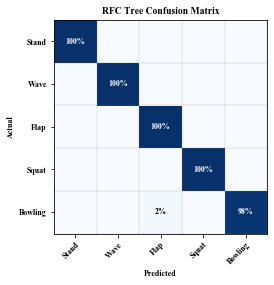

In [12]:
plot_Matrix(cm, labels_name, "RFC Tree Confusion Matrix")

In [13]:
# 导出sklearn模型
joblib.dump(rfc, "rfc_model.m")

['rfc_model.m']

In [14]:
input =  [0.42, 0.0, 0.33, 0.14, 0.17, 0.14, 0.08, 0.31, 0.0, 0.48, 0.5, 0.14, 0.75, 0.1, 1.0, 0.03, 0.25, 0.48, 0.25, 0.76, 0.17, 1.0, 0.42, 0.48, 0.42, 0.76, 0.42, 1.0, 0.33, 0.0, 0.42, 0.0, 0.25, 0.0, 0.42, 0.03]
input  = np.array(input).reshape((1, 36))
pred_output  = rfc.predict(input)
print(pred_output)

[1]
